## 기초 데이터 로드 (Amazon Products)

In [ ]:
#!pip install pandas sentence-transformers network langchain kaggle fuzzywuzzy
#!kaggle datasets download -d piyushjain16/amazon-product-data

In [ ]:
#!unzip amazon-product-data.zip && mv dataset/train.csv dataset/amazon_products.csv

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import networkx as nx
from networkx import connected_components
import pandas as pd
from sentence_transformers import SentenceTransformer, util

In [2]:
data = pd.read_csv("dataset/amazon_products.csv")
data['TITLE'].fillna('', inplace=True)
data['BULLET_POINTS'].fillna('', inplace=True)
data['DESCRIPTION'].fillna('', inplace=True)
data['text'] = data['TITLE'] + data['BULLET_POINTS'] + data['DESCRIPTION']
data

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,text
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,,1650,2125.980000,ArtzFolio Tulip Flowers Blackout Curtain for D...
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",,2755,393.700000,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
4,283658,The United Empire Loyalists: A Chronicle of th...,,,6112,598.424000,The United Empire Loyalists: A Chronicle of th...
...,...,...,...,...,...,...,...
2249693,2422167,Nike Women's As W Ny Df Swsh Hn Kh Bra (CZ7610...,Material : Polyester,,3009,1181.100000,Nike Women's As W Ny Df Swsh Hn Kh Bra (CZ7610...
2249694,2766635,"(3PCS) Goose Game Cute Cartoon Enamel Pins, Fu...",[❤ [Inspiration] Inspired by the Untitled Goos...,<p><b>[Brand]: </b>XVIEONR</p> <p><br></p> <p>...,3413,125.984252,"(3PCS) Goose Game Cute Cartoon Enamel Pins, Fu..."
2249695,1987786,Kangroo Sweep Movement Printed Wooden Wall Clo...,"[Dial size: 12 inches in diameter,Big, clear r...",Wall Clocks Are Very Attractive In Looks And E...,1574,1200.000000,Kangroo Sweep Movement Printed Wooden Wall Clo...
2249696,1165754,Electro Voice EKX-BRKT15 | Wall Mount Bracket ...,,,592,2900.000000,Electro Voice EKX-BRKT15 | Wall Mount Bracket ...


## 엔티티 추출 규칙 정의

In [3]:
entity_types = {
  "product": "https://schema.org/Product", 
  "rating": "https://schema.org/AggregateRating",
  "price": "https://schema.org/Offer", 
  "characteristic": "https://schema.org/PropertyValue", 
  "material": "https://schema.org/Text",
  "manufacturer": "https://schema.org/Organization", 
  "brand": "https://schema.org/Brand", 
  "measurement": "https://schema.org/QuantitativeValue", 
  "organization": "https://schema.org/Organization",  
  "color": "https://schema.org/Text",
}

relation_types = {
  "hasCharacteristic": "https://schema.org/additionalProperty",
  "hasColor": "https://schema.org/color", 
  "hasBrand": "https://schema.org/brand", 
  "isProducedBy": "https://schema.org/manufacturer", 
  "hasColor": "https://schema.org/color",
  "hasMeasurement": "https://schema.org/hasMeasurement", 
  "isSimilarTo": "https://schema.org/isSimilarTo", 
  "madeOfMaterial": "https://schema.org/material", 
  "hasPrice": "https://schema.org/offers", 
  "hasRating": "https://schema.org/aggregateRating", 
  "relatedTo": "https://schema.org/isRelatedTo"
 }

In [4]:
prompt_template = """

Human: You are an expert agent specialized in analyzing product specifications in an online retail store.
Your task is to identify the entities and relations requested with the user prompt, from a given product specification.
You must generate the output in a JSON containing a list with strict JSON objects having the following keys: "head", "head_type", "relation", "tail", and "tail_type".
The "head" key must represent a product name, and all heads should be identical.
The "head_type" key must contain the type of the extracted head entity which must be one of the types from the provided user list,
The "relation" key must contain the type of relation between the "head" and the "tail". DO NOT use "relation"  not specified in the ENTITY TYPES.
The "tail" key must represent the text of an extracted entity which is the tail of the relation, 
The "tail_type" key must contain the type of the tail entity. Attempt to extract as many entities and relations as you can.
If a double quote is found within the identified entity, replace it with a single quote.
Based on the following example, extract entities and relations from the provided text.
Use the following entity types:

# ENTITY TYPES:
{entity_types}

Use the following relation types:
{relation_types}

--> Beginning of example

# Specification
"YUVORA 3D Brick Wall Stickers | PE Foam Fancy Wallpaper for Walls,
 Waterproof & Self Adhesive, White Color 3D Latest Unique Design Wallpaper for Home (70*70 CMT) -40 Tiles
 [Made of soft PE foam,Anti Children's Collision,take care of your family.Waterproof, moist-proof and sound insulated. Easy clean and maintenance with wet cloth,economic wall covering material.,Self adhesive peel and stick wallpaper,Easy paste And removement .Easy To cut DIY the shape according to your room area,The embossed 3d wall sticker offers stunning visual impact. the tiles are light, water proof, anti-collision, they can be installed in minutes over a clean and sleek surface without any mess or specialized tools, and never crack with time.,Peel and stick 3d wallpaper is also an economic wall covering material, they will remain on your walls for as long as you wish them to be. The tiles can also be easily installed directly over existing panels or smooth surface.,Usage range: Featured walls,Kitchen,bedroom,living room, dinning room,TV walls,sofa background,office wall decoration,etc. Don't use in shower and rugged wall surface]
Provide high quality foam 3D wall panels self adhesive peel and stick wallpaper, made of soft PE foam,children's collision, waterproof, moist-proof and sound insulated,easy cleaning and maintenance with wet cloth,economic wall covering material, the material of 3D foam wallpaper is SAFE, easy to paste and remove . Easy to cut DIY the shape according to your decor area. Offers best quality products. This wallpaper we are is a real wallpaper with factory done self adhesive backing. You would be glad that you it. Product features High-density foaming technology Total Three production processes Can be use of up to 10 years Surface Treatment: 3D Deep Embossing Damask Pattern."

################

# Output
[
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "isProducedBy",
    "tail": "YUVORA",
    "tail_type": "manufacturer"
  }},
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "hasCharacteristic",
    "tail": "Waterproof",
    "tail_type": "characteristic"
  }},
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "hasCharacteristic",
    "tail": "Self Adhesive",
    "tail_type": "characteristic"
  }},
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "hasColor",
    "tail": "White",
    "tail_type": "color"
  }},
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "hasMeasurement",
    "tail": "70*70 CMT",
    "tail_type": "measurement"
  }},
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "hasMeasurement",
    "tail": "40 tiles",
    "tail_type": "measurement"
  }},
  {{
    "head": "YUVORA 3D Brick Wall Stickers",
    "head_type": "product",
    "relation": "hasMeasurement",
    "tail": "40 tiles",
    "tail_type": "measurement"
  }}
]

--> End of example

For the following specification, generate extract entitites and relations as in the provided example.
# Specification
{specification}
################

# Output

Assistant:"""

## [Bedrock] Plain Text에서 그래프 추출

In [694]:
import boto3
from langchain.prompts import PromptTemplate
from langchain.llms.bedrock import Bedrock

boto3_bedrock = boto3.client('bedrock-runtime', region_name='us-east-1')
llm = Bedrock(model_id="anthropic.claude-v2:1", client=boto3_bedrock, model_kwargs={'max_tokens_to_sample':10240, "temperature": 0})

In [187]:
rel_list = []
num_products = 20

for index, content in data[:num_products].iterrows():
    try:
        prompt = PromptTemplate.from_template(prompt_template)
        response = llm(prompt.format(entity_types=entity_types, relation_types=relation_types, specification=content['text']))
        json_start = response.find("[")
        json_end = response.rfind("]") + 1
        json_part = response[json_start:json_end]
        
        if json_start != -1 and json_end != 0:
            json_part_list = json.loads(json_part)
        else:
            json_part_list = [{"head": content['TITLE'], "head_type": "product"}]
    
        for item in json_part_list:
            item['pid'] = content['PRODUCT_ID']
            item['category'] = content['PRODUCT_TYPE_ID']
            rel_list.append(item)
        
    except Exception as e:
        print(response)
        logging.error(e)

graph_df = pd.DataFrame(rel_list)
graph_df

,head,head_type,relation,tail,tail_type,pid,category
0,ArtzFolio Tulip Flowers Blackout Curtain,product,hasCharacteristic,Luxurious,characteristic,1925202,1650
1,ArtzFolio Tulip Flowers Blackout Curtain,product,hasCharacteristic,Appealing,characteristic,1925202,1650
2,ArtzFolio Tulip Flowers Blackout Curtain,product,madeOfMaterial,Cotton Canvas,material,1925202,1650
3,ArtzFolio Tulip Flowers Blackout Curtain,product,hasMeasurement,Width 4.5feet (54inch),measurement,1925202,1650
4,ArtzFolio Tulip Flowers Blackout Curtain,product,hasMeasurement,Height 5 feet (60 inch),measurement,1925202,1650
...,...,...,...,...,...,...,...
99,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasColor,Cognac,color,1543564,3247
100,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasMeasurement,10 M US,measurement,1543564,3247
101,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasCharacteristic,Burnished metal center bit,characteristic,1543564,3247
102,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasCharacteristic,Slightly padded Footbed,characteristic,1543564,3247


### -데이터 정제

In [240]:
from fuzzywuzzy import fuzz
import numpy as np

def show_similar_feature(df):
    similar_features = pd.DataFrame()
    tail_data = df.loc[~df['tail_type'].isin(['measurement', 'product']), ['tail', 'tail_type']]
    tail_data = tail_data.drop_duplicates()

    tail_column = set(zip(tail_data['tail'], tail_data['tail_type']))
    
    for current_name, current_type in tail_column:
        similar_nodes = [(name, tail_type) for name, tail_type in tail_column if fuzz.token_sort_ratio(name, current_name) > 80 and name != current_name]
        for similar_name, similar_type in similar_nodes:
            similar_pair = pd.DataFrame({'A': [current_name], 'B': [similar_name]})
            similar_features = pd.concat([similar_features, similar_pair], ignore_index=True)
                
    return similar_features

def combine_similar_feature(df):
    temp_df = df.copy()
    tail_data = temp_df.loc[~temp_df['tail_type'].isin(['measurement', 'product']), ['tail', 'tail_type']]
    tail_data = tail_data.drop_duplicates()

    tail_column = set(zip(tail_data['tail'], tail_data['tail_type']))
    
    for current_name, current_type in tail_column:
        similar_nodes = [(name, tail_type) for name, tail_type in tail_column if fuzz.token_sort_ratio(name, current_name) > 80 and name != current_name]
        for similar_name, similar_type in similar_nodes:
            combined_name = f"{current_name} | {similar_name}"
            temp_df.loc[temp_df['tail'] == current_name, 'tail'] = combined_name
            temp_df.loc[temp_df['tail'] == similar_name, 'tail'] = combined_name
            temp_df.loc[temp_df['tail'] == similar_name, 'tail_type'] = current_type
                
    return temp_df

def clean_data(df):
    temp_df = df.copy()
    heads = temp_df.groupby('pid')['head'].first().to_dict()
    temp_df['head'] = temp_df['pid'].map(heads)
    
    return temp_df.drop_duplicates()

In [233]:
show_similar_feature(graph_df)

,A,B
0,NaN,NaN


In [234]:
combined_df = combine_similar_feature(graph_df)

In [241]:
combined_df = clean_data(combined_df)
combined_df

,head,head_type,relation,tail,tail_type,pid,category
0,ArtzFolio Tulip Flowers Blackout Curtain,product,hasCharacteristic,Luxurious,characteristic,1925202,1650
1,ArtzFolio Tulip Flowers Blackout Curtain,product,hasCharacteristic,Appealing,characteristic,1925202,1650
2,ArtzFolio Tulip Flowers Blackout Curtain,product,madeOfMaterial,Cotton Canvas,material,1925202,1650
3,ArtzFolio Tulip Flowers Blackout Curtain,product,hasMeasurement,Width 4.5feet (54inch),measurement,1925202,1650
4,ArtzFolio Tulip Flowers Blackout Curtain,product,hasMeasurement,Height 5 feet (60 inch),measurement,1925202,1650
...,...,...,...,...,...,...,...
99,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasColor,Cognac,color,1543564,3247
100,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasMeasurement,10 M US,measurement,1543564,3247
101,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasCharacteristic,Burnished metal center bit,characteristic,1543564,3247
102,Kenneth Cole REACTION Men's Crespo Loafer B Shoe,product,hasCharacteristic,Slightly padded Footbed,characteristic,1543564,3247


In [244]:
G = nx.Graph()
for _, row in graph_df.iterrows():
  G.add_edge(row['head'], row['tail'], label=row['relation'])

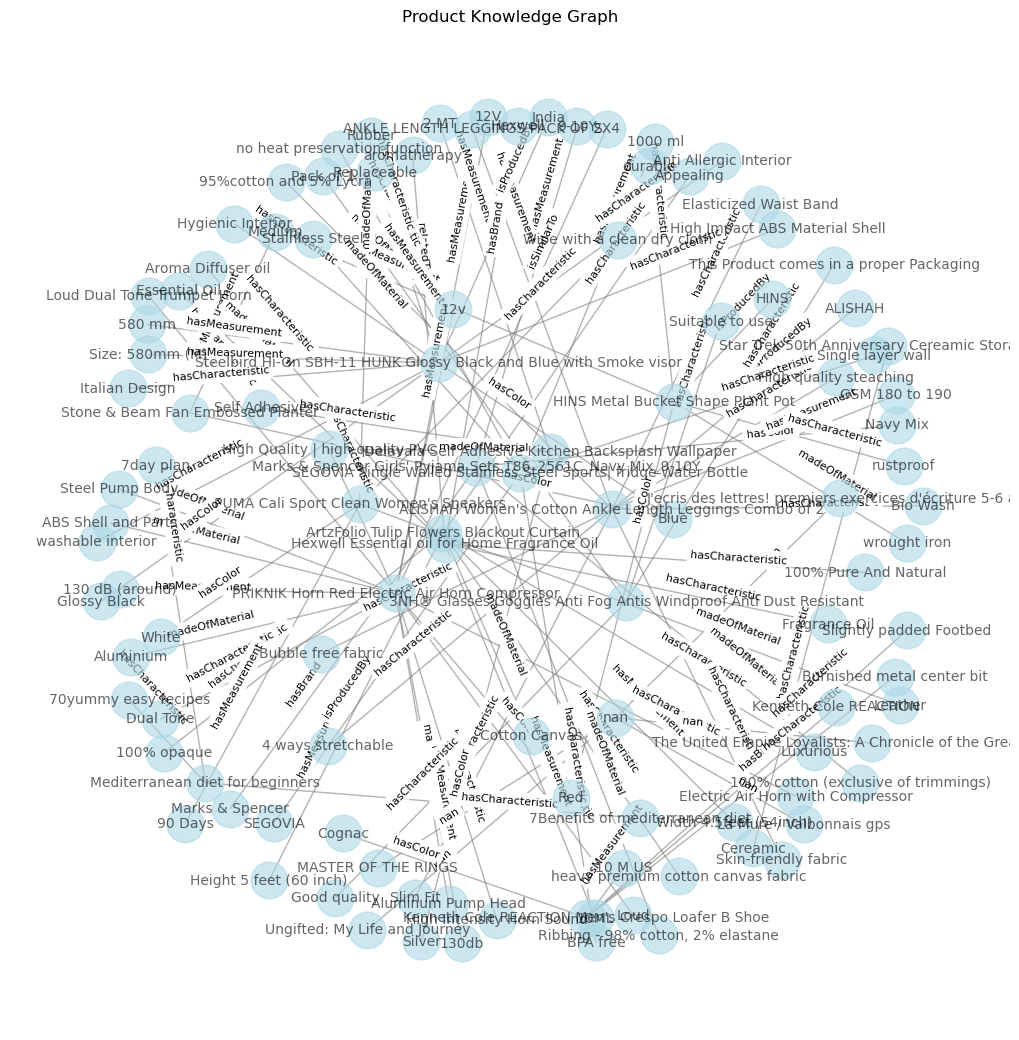

In [245]:
pos = nx.spring_layout(G, seed=47, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Product Knowledge Graph')
plt.show()

## Neo4j 설정

In [336]:
from py2neo import Graph, Node, Relationship
from graphdatascience import GraphDataScience
uri = "bolt://{ip_address}:7687"
username = "{username}"
password = "{password}"
graph = Graph(uri, auth=(username, password))
gds = GraphDataScience(
    uri,
    auth=(username, password),
    aura_ds=False
)

In [246]:
def init_index_constraint():
    graph.run("MATCH (n) DETACH DELETE n")
    gds.run_cypher('CREATE INDEX product_name IF NOT EXISTS FOR (n:Product) ON (n.name)')
    gds.run_cypher('CREATE CONSTRAINT unique_document_id IF NOT EXISTS FOR (n:Document) REQUIRE (n.documentId) IS UNIQUE')

In [259]:
init_index_constraint()

## [Bedrock] 텍스트 임베딩 및 그래프 로드

In [13]:
data['text'].apply(len).max()

8122

### -임베딩 생성

In [14]:
from langchain.embeddings import BedrockEmbeddings
EMBEDDING_MODEL = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=boto3_bedrock, region_name='us-east-1')

In [248]:
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunks(xs, n=3):
    n = max(1, n)
    return [xs[i:i + n] for i in range(0, len(xs), n)]
    
def create_text_embedding_entries(df):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=15,
        length_function=len,
        is_separator_regex=False,
    )
    embedding_entries = []
    
    for index, row in df.iterrows():
        if index % 100 == 0:
            print(f"Processing {index} of {len(df)}")
        
        input_text = row['text']
        product_name = row['TITLE']
        pid = row['PRODUCT_ID']
        
        res = []    
        seq_id = -1
        docs = text_splitter.split_text(input_text)
        
        for d in chunks(docs):
            embeddings = EMBEDDING_MODEL.embed_documents(d)
            for i in range(len(d)):
                seq_id += 1
                res.append({'product': product_name,
                            'pid': pid,
                            'seqId': seq_id,
                            'contextId': product_name + str(seq_id),  # unique 
                            'textEmbedding': embeddings[i],  # chunked
                            'text': d[i]  })
        embedding_entries.extend(res)
    print("Done.")
    return embedding_entries

In [249]:
def matching_title(data_subset, df):
    for idx, row in data_subset.iterrows():
        matching = df[df['pid']==row['PRODUCT_ID']]
        if not matching.empty:
            data_subset.at[idx, 'TITLE'] = matching['head'].iloc[0]

In [251]:
data_subset = data[:num_products]
matching_title(data_subset, combined_df)

In [252]:
embeddings = pd.DataFrame(create_text_embedding_entries(data_subset))
emb = embeddings.to_dict(orient='records')

Processing 0 of 20
Done.


In [328]:
embeddings

,product,pid,seqId,contextId,textEmbedding,text
0,ArtzFolio Tulip Flowers Blackout Curtain,1925202,0,ArtzFolio Tulip Flowers Blackout Curtain0,"[0.19921875, -0.08984375, -0.16601562, 0.03637...",ArtzFolio Tulip Flowers Blackout Curtain for D...
1,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,2673191,0,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[0.010253906, 0.12695312, 0.54296875, -0.15332...",Marks & Spencer Girls' Pyjama Sets T86_2561C_N...
2,PRIKNIK Horn Red Electric Air Horn Compressor,2765088,0,PRIKNIK Horn Red Electric Air Horn Compressor0,"[-0.234375, 0.33789062, -0.35546875, 0.1079101...",PRIKNIK Horn Red Electric Air Horn Compressor ...
3,ALISHAH Women's Cotton Ankle Length Leggings C...,1594019,0,ALISHAH Women's Cotton Ankle Length Leggings C...,"[-0.41796875, 0.47265625, 0.079589844, -0.4042...",ALISHAH Women's Cotton Ankle Length Leggings C...
4,The United Empire Loyalists: A Chronicle of th...,283658,0,The United Empire Loyalists: A Chronicle of th...,"[-0.66796875, -0.546875, 0.29492188, -0.167968...",The United Empire Loyalists: A Chronicle of th...
5,HINS Metal Bucket Shape Plant Pot,2152929,0,HINS Metal Bucket Shape Plant Pot0,"[0.92578125, -0.00078201294, -0.11621094, -0.0...",HINS Metal Bucket Shape Plant Pot for Indoor &...
6,Ungifted: My Life and Journey,413758,0,Ungifted: My Life and Journey0,"[-0.69140625, -0.53515625, 0.29101562, -0.0585...",Ungifted: My Life and Journey
7,Delavala Self Adhesive Kitchen Backsplash Wall...,2026580,0,Delavala Self Adhesive Kitchen Backsplash Wall...,"[0.56640625, -0.16796875, -0.16308594, 0.46484...",Delavala Self Adhesive Kitchen Backsplash Wall...
8,Delavala Self Adhesive Kitchen Backsplash Wall...,2026580,1,Delavala Self Adhesive Kitchen Backsplash Wall...,"[0.59375, -0.22363281, -0.035888672, 0.6328125...",long time and will not deform. &nbsp;</strong>...
9,PUMA Cali Sport Clean Women's Sneakers,2050239,0,PUMA Cali Sport Clean Women's Sneakers0,"[0.21289062, 0.23046875, -0.3125, 0.14746094, ...",PUMA Cali Sport Clean Women's Sneakers White L...


### -노드 초기화 및 임베딩 로드

In [253]:
def update_embeddings(emb):
    total = len(emb)
    count = 0
    for d in chunks(emb, 100):
        gds.run_cypher('''
        UNWIND $records AS record
        MERGE(p:Product {pid:record.pid, name:record.product})
        MERGE(b:Document {documentId:record.contextId})
        SET b.seqId = record.seqId, b.textEmbedding = record.textEmbedding, b.text = record.text
        MERGE(p)-[:hasInformation]->(b)
        RETURN count(b) as cnt
        ''', params = {'records':d})
        count += len(d)

In [260]:
update_embeddings(emb)

#### [Neo4j 그래프 확인]
제품 별 정보를 임베딩으로 변환하여, "hasInformation" relation으로 등록

### -그래프 Relation 로드

In [262]:
def create_relation(data):
    for d in chunks(data, 100):
        p2p = [record for record in d if record['tail_type'] == 'product']
        p2c = [record for record in d if record['tail_type'] != 'product']
        gds.run_cypher('''
        UNWIND $records AS record
        MATCH (p:Product {name: record.head})
        SET p.category = record.category, p.pid = record.pid
        WITH record, p
        WHERE NOT (record.tail IS NULL OR toString(record.tail) = 'NaN' OR record.tail = '')
        MERGE (c:Characteristic {name: record.tail})
        ON CREATE SET c.type = record.tail_type
        WITH record, p, c
        CALL apoc.create.relationship(p, COALESCE(record.relation, 'DEFAULT_RELATIONSHIP'), {}, c) YIELD rel
        RETURN rel
        ''', params = {'records':p2c})
        gds.run_cypher('''
        UNWIND $records AS record
        MATCH (p:Product {name: record.head})
        SET p.category = record.category, p.pid = record.pid
        WITH record, p
        MERGE (t:Product {name: record.tail})
        WITH record, p, t
        CALL apoc.create.relationship(p, COALESCE(record.relation, 'DEFAULT_RELATIONSHIP'), {}, t) YIELD rel
        RETURN rel
        ''', params = {'records':p2p})

In [263]:
graph_entries = combined_df.to_dict(orient='records')
create_relation(graph_entries)

## [Bedrock] 배치 추론으로 대규모 그래프 추출

In [ ]:
# !wget "https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip"
# !cd pyton-sdk && unzip "bedrock-python-sdk-reinvent.zip"
# !cd python-sdk && pip install ./botocore-1.32.4-py3-none-any.whl ./boto3-1.29.4-py3-none-any.whl

### -배치 추론 input 생성

In [53]:
from datetime import datetime
import pytz

current_time_kst = datetime.now(pytz.timezone('Asia/Seoul'))
formatted_date = current_time_kst.strftime("%Y-%m-%d")
formatted_time = current_time_kst.strftime("%H-%M-%S")

s3_client = boto3.client('s3')
bucket_name = "us-test-bucket-168253315588" 

input_path = f'batch/input/{formatted_date}/{formatted_time}'
output_path = f'batch/output/{formatted_date}/{formatted_time}'

In [54]:
import uuid
num_products = 1000
batch_size = 100
req_interval = 1200
subset_data = data['text'].values[:num_products]

def create_batch_input(dataset, batch_size):
    prompt_list = []
    filenames = []
    file_index = 0
    for idx, content in enumerate(subset_data):
        prompt = PromptTemplate.from_template(prompt_template)
        record = {
            "recordId": str(idx).zfill(12),
            "modelInput": {
                "prompt": prompt.format(entity_types=entity_types, relation_types=relation_types, specification=content),
                "temperature": 0,
                "max_tokens_to_sample": 10240
            }
        }
        prompt_list.append(record)
    
        if len(prompt_list) == batch_size or idx == len(subset_data) - 1:
            formatted_data = "\n".join(json.dumps(item) for item in prompt_list)
            filename = f'{file_index}_{formatted_time}'
            try:
                s3_client.put_object(Body=formatted_data, Bucket=bucket_name, Key=f'{input_path}/{filename}.jsonl')
            except Exception as e:
                logging.error(f"Error putting object in S3: {e}")
                continue
            filenames.append(filename)
            file_index += 1
            prompt_list = []
    return filenames

filenames = create_batch_input(subset_data, batch_size)
print(filenames)

['0_17-01-44', '1_17-01-44', '2_17-01-44', '3_17-01-44', '4_17-01-44', '5_17-01-44', '6_17-01-44', '7_17-01-44', '8_17-01-44', '9_17-01-44']


### -배치 추론 실행

In [ ]:
import time
bedrock = boto3.client(service_name="bedrock", region_name='us-east-1')

def create_batch_inference(bedrock, filenames):
    jobArns = []
    for filename in filenames:
        inputDataConfig = ({
            "s3InputDataConfig": {
                "s3Uri": f"s3://{bucket_name}/{input_path}/{filename}.jsonl"
            }
        })
        outputDataConfig = ({
            "s3OutputDataConfig": {
                "s3Uri": f"s3://{bucket_name}/{output_path}/"
            }
        })
        response = bedrock.create_model_invocation_job(
            roleArn="arn:aws:iam::168253315588:role/BedrockRole",
            modelId="anthropic.claude-v2:1",
            jobName=str(uuid.uuid4())[:8],
            inputDataConfig=inputDataConfig,
            outputDataConfig=outputDataConfig
        )
        print(response.get('jobArn'))
        jobArns.append(response.get('jobArn'))
        time.sleep(req_interval)
    return jobArns

jobArns = create_batch_inference(bedrock, filenames)

arn:aws:bedrock:us-east-1:168253315588:model-invocation-job/bmdz7cqs24xy
arn:aws:bedrock:us-east-1:168253315588:model-invocation-job/27awqm1kyqma


In [57]:
response = bedrock.list_model_invocation_jobs()
pd.DataFrame(response['invocationJobSummaries']).head(20)

,jobArn,jobName,modelId,roleArn,status,submitTime,lastModifiedTime
0,arn:aws:bedrock:us-east-1:168253315588:model-i...,c94165ae,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 11:02:25.977000+00:00,2023-12-14 11:53:47.246000+00:00
1,arn:aws:bedrock:us-east-1:168253315588:model-i...,0094706a,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 10:42:25.093000+00:00,2023-12-14 11:32:15.753000+00:00
2,arn:aws:bedrock:us-east-1:168253315588:model-i...,d1edaa51,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 10:22:23.936000+00:00,2023-12-14 11:11:00.350000+00:00
3,arn:aws:bedrock:us-east-1:168253315588:model-i...,d015bc87,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 10:02:23.125000+00:00,2023-12-14 10:49:37.351000+00:00
4,arn:aws:bedrock:us-east-1:168253315588:model-i...,71fde4b1,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 09:42:22.229000+00:00,2023-12-14 10:26:27.480000+00:00
5,arn:aws:bedrock:us-east-1:168253315588:model-i...,2945a606,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 09:22:21.243000+00:00,2023-12-14 10:03:53.576000+00:00
6,arn:aws:bedrock:us-east-1:168253315588:model-i...,3e552395,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 09:02:20.141000+00:00,2023-12-14 09:39:50.102000+00:00
7,arn:aws:bedrock:us-east-1:168253315588:model-i...,df0596bb,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 08:42:19.218000+00:00,2023-12-14 09:18:40.937000+00:00
8,arn:aws:bedrock:us-east-1:168253315588:model-i...,1f4e1901,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 08:22:18.342000+00:00,2023-12-14 08:57:33.827000+00:00
9,arn:aws:bedrock:us-east-1:168253315588:model-i...,ba422027,arn:aws:bedrock:us-east-1::foundation-model/an...,arn:aws:iam::168253315588:role/BedrockRole,Completed,2023-12-14 08:02:17.436000+00:00,2023-12-14 08:33:11.470000+00:00


### -배치 추론 상태 추적

In [58]:
for job in jobArns:
    response = bedrock.get_model_invocation_job(
        jobIdentifier=job
    )
    s3_input_path = response['inputDataConfig']['s3InputDataConfig']['s3Uri']
    submit_time = response['submitTime']
    status = response['status']
    
    print(f"Input S3 Path: {s3_input_path}")
    print(f"Submit Time: {submit_time}")
    print(f"Status: {status}")

Input S3 Path: s3://us-test-bucket-168253315588/batch/input/2023-12-14/17-01-44/0_17-01-44.jsonl
Submit Time: 2023-12-14 08:02:17.436000+00:00
Status: Completed
Input S3 Path: s3://us-test-bucket-168253315588/batch/input/2023-12-14/17-01-44/1_17-01-44.jsonl
Submit Time: 2023-12-14 08:22:18.342000+00:00
Status: Completed
Input S3 Path: s3://us-test-bucket-168253315588/batch/input/2023-12-14/17-01-44/2_17-01-44.jsonl
Submit Time: 2023-12-14 08:42:19.218000+00:00
Status: Completed
Input S3 Path: s3://us-test-bucket-168253315588/batch/input/2023-12-14/17-01-44/3_17-01-44.jsonl
Submit Time: 2023-12-14 09:02:20.141000+00:00
Status: Completed
Input S3 Path: s3://us-test-bucket-168253315588/batch/input/2023-12-14/17-01-44/4_17-01-44.jsonl
Submit Time: 2023-12-14 09:22:21.243000+00:00
Status: Completed
Input S3 Path: s3://us-test-bucket-168253315588/batch/input/2023-12-14/17-01-44/5_17-01-44.jsonl
Submit Time: 2023-12-14 09:42:22.229000+00:00
Status: Completed
Input S3 Path: s3://us-test-bucket

### -배치 결과 불러오기

In [267]:
input_path = 'batch/input/2023-12-14/17-01-44'
output_path = 'batch/output/2023-12-14/17-01-44'
num_products = 1000

In [268]:
import json, re
import pandas as pd

def read_s3_file(bucket_name, file_key):
    file_obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return file_obj['Body'].read().decode('utf-8')

def load_graph(completion, df, pid, category, name):
    graph_pattern = re.compile(r'{.*?}', re.DOTALL)
    matches = list(graph_pattern.finditer(completion))
    
    if matches:
        for match in matches:  # each relation
            relation = match.group()
            try:
                relation = json.loads(relation)
                relation['pid'] = pid
                relation['category'] = category
                df = pd.concat([df, pd.DataFrame([relation])], ignore_index=True)
            except json.JSONDecodeError as e:
                print(f"This relation has been skipped because of the JSON formatting issues.\n{relation}")
    else:
        relation = {
            'head': name,
            'head_type': 'product',
            'pid': pid,
            'category': category
        }
        df = pd.concat([df, pd.DataFrame([relation])], ignore_index=True)

    return df

def process_json_line(line, df, product_data, record_id):
    try:
        json_part = json.loads(line)
        completion = json_part.get('modelOutput', {}).get('completion', '')
    
        if record_id < len(product_data):
            df = load_graph(completion, df, product_data['PRODUCT_ID'][record_id], \
                            product_data['PRODUCT_TYPE_ID'][record_id], product_data['TITLE'][record_id])
    except json.JSONDecodeError as e:
        logging.error(f"JSONDecodeError: {e}")
    return df
    
def parse_output_file(bucket_name, response, product_data):
    df = pd.DataFrame()
    for obj in response.get('Contents', []):
        file_key = obj['Key']
        if file_key.endswith('jsonl.out'):  # each file 
            content = read_s3_file(bucket_name, file_key)
            for line in content.split('\n'):  # each product
                if line:
                    record_id = int(json.loads(line).get('recordId', 0))
                    df = process_json_line(line, df, product_data, record_id)
    return df
            
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=output_path)
product_subset = data.iloc[:num_products][['PRODUCT_ID', 'PRODUCT_TYPE_ID', 'TITLE']]
batch_df = parse_output_file(bucket_name, response, product_subset)

This relation has been skipped because of the JSON formatting issues.
{
    "head": "2022 Boston Calendar",
    "head_type": "product",
    "relation": "hasCharacteristic",
    "tail": "Every game for the entire season', so you"re sure not to miss a thing!",
    "tail_type": "characteristic"
  }
This relation has been skipped because of the JSON formatting issues.
{
    "head": "2022 Boston Calendar",
    "head_type": "product",
    "relation": "hasMeasurement",
    "tail": "12" x 24" open",
    "tail_type": "measurement"
  }
This relation has been skipped because of the JSON formatting issues.
{
    "head": "Foreside Home and Garden Art Multi Wreath Floral Wall",
    "head_type": "product",
    "relation": "hasMeasurement",
    "tail": "39. 5 x 2. 5 x 30"H"",
    "tail_type": "measurement"
  }
This relation has been skipped because of the JSON formatting issues.
{
    "head": "Redesigned Headband",
    "head_type": "product", 
    "relation": "hasCharacteristic",
    "tail": "Unique D

In [269]:
print("number of products:", batch_df['pid'].nunique())
batch_df

number of products: 1000


,head,head_type,relation,tail,tail_type,pid,category
0,Tales of Cydonia: Volume Two: Cydonia Labyrint...,product,isSimilarTo,Tales of Cydonia: Volume Two: Cydonia Labyrinthus,product,402457,1
1,Protective Case Compatible with MacBook Air 11...,product,isSimilarTo,MacBook Air 11 inch Models A1465 & A1370,product,2535905,712
2,Protective Case Compatible with MacBook Air 11...,product,hasCharacteristic,Plastic Hard Shell Cover Case,characteristic,2535905,712
3,Protective Case Compatible with MacBook Air 11...,product,hasCharacteristic,Laptop Sleeve Bag,characteristic,2535905,712
4,Protective Case Compatible with MacBook Air 11...,product,hasCharacteristic,Keyboard Cover,characteristic,2535905,712
...,...,...,...,...,...,...,...
4413,Megaslim II 0.47L Stainless Steel,product,hasCharacteristic,Twist-top lid,characteristic,1171454,1352
4414,Megaslim II 0.47L Stainless Steel,product,hasCharacteristic,Exterior rubber trim,characteristic,1171454,1352
4415,Megaslim II 0.47L Stainless Steel,product,hasCharacteristic,sleek metallic finish,characteristic,1171454,1352
4416,Compartment Syndrome: A Guide to Diagnosis and...,product,NaN,NaN,NaN,667106,6253


### -데이터 전처리

In [270]:
show_similar_feature(batch_df)

,A,B
0,Round toe,Round Toe
1,cotton,Cotton
2,cotton,Cotton
3,Machine washable,Machine Washable
4,Machine washable,Machine Washable Sheet
...,...,...
904,decorative,Decorative
905,Impact Resistant,Impact resistant
906,gallery wrapped canvas,Gallery-Wrapped
907,gallery wrapped canvas,Gallery-Wrapped Canvas Art


### -배치 결과에 임베딩 생성

In [272]:
batch_subset = data[:num_products]
matching_title(batch_subset, combined_df)

In [273]:
batch_subset

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,text
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain,[LUXURIOUS & APPEALING: Beautiful custom-made ...,,1650,2125.980000,ArtzFolio Tulip Flowers Blackout Curtain for D...
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",,2755,393.700000,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
4,283658,The United Empire Loyalists: A Chronicle of th...,,,6112,598.424000,The United Empire Loyalists: A Chronicle of th...
...,...,...,...,...,...,...,...
995,1997414,Green India Napier grass seeds,NAPIER GRASS (Pennisetum purpureum) is popular...,Green India - Napier Elephant Pennisetum Purpu...,6503,708.661417,"Green India Napier grass seeds, Elephant grass..."
996,219646,Carranza and His Bolshevik Regime,,,6108,500.000000,Carranza and His Bolshevik Regime
997,2824714,HiEnd Accents Stella Faux Silk Velvet Western ...,[DECORATIVE PILLOW: (1) Floral Embroidered Lum...,,7258,2400.000000,HiEnd Accents Stella Faux Silk Velvet Western ...
998,1563344,Lilis Women's Slim 2 Piece Suits,[MATERIAL: Polyester.No iron fabric.The good q...,,3063,1181.102361,Lilis Women's Slim 2 Piece Suits Lady Blazer P...


In [274]:
batch_embeddings = pd.DataFrame(create_text_embedding_entries(batch_subset))
batch_emb = batch_embeddings.to_dict(orient='records')

Processing 0 of 1000
Processing 100 of 1000
Processing 200 of 1000
Processing 300 of 1000
Processing 400 of 1000
Processing 500 of 1000
Processing 600 of 1000
Processing 700 of 1000
Processing 800 of 1000
Processing 900 of 1000
Done.


### -노드 초기화 및 임베딩 로드

In [337]:
init_index_constraint()

In [338]:
update_embeddings(batch_emb)

#### [Neo4j 그래프 확인]
제품 별 정보를 임베딩으로 변환하여, "hasInformation" relation으로 등록\
기본 설정에서 node4js는 300개의 노드만 화면에 표시합니다. \
브라우저 좌측 하단 설정의 'Graph Visualization'을 수정해서, 화면에 표시되는 노드 수를 조절할 수 있습니다.

<img src="./images/text_emb.png">

### -그래프 Relation 로드

In [339]:
batch_entries = combined_df.to_dict(orient='records')
create_relation(batch_entries)

<img src="./images/relation.png">

## 그래프 탐색

### -Vector 인덱스 생성
createNodeIndex('인덱스 이름', '레이블', 'Key', 벡터 차원 수, '벡터 유사도 함수')

In [340]:
gds.run_cypher("CALL db.index.vector.createNodeIndex('document-embeddings', 'Document', 'textEmbedding', 1536, 'cosine')")

""


In [341]:
gds.run_cypher(''' 
SHOW INDEXES YIELD name, type, labelsOrTypes, properties, options
WHERE type = "VECTOR"
''')

,name,type,labelsOrTypes,properties,options
0,document-embeddings,VECTOR,[Document],[textEmbedding],"{'indexProvider': 'vector-1.0', 'indexConfig':..."


### -Vector embedding 기반 텍스트 검색
https://python.langchain.com/docs/integrations/vectorstores/neo4jvector

https://neo4j.com/docs/cypher-manual/current/indexes-for-vector-search/

In [342]:
from langchain.docstore.document import Document
from typing import (
    List,
    Tuple,
)

def to_df(results: List[Tuple[Document, float]]):
    return pd.DataFrame({
        "doc_id": [r[0].metadata.get('documentId') for r in results],
        "score": [r[1] for r in results],
        "text": [r[0].page_content for r in results]
    })

In [343]:
query = 'What are the products associated with home furniture?'

In [344]:
llm(query)

' Here are some of the main categories of products associated with home furniture:\n\n- Upholstered furniture - This includes sofas, armchairs, ottomans, etc. It is available in a wide variety of fabrics and styles. Brands include Ashley Furniture, La-Z-Boy, Crate & Barrel, etc.\n\n- Bedroom furniture - Beds, mattresses, dressers, nightstands, armoires, etc. Major brands are Ashley Furniture, Rooms To Go, IKEA.\n\n- Dining room furniture - Tables, chairs, benches, hutches, buffets, etc. Amish furniture makers and brands like Ashley Furniture, Thomasville are top providers.  \n\n- Occasional furniture - Accent chairs, coffee tables, end tables, TV stands, etc. that are used to complement other furniture. Main brands - IKEA, Crate & Barrel, Pottery Barn.\n\n- Outdoor patio furniture - Patio sets, chairs, tables, umbrellas used outdoors. Trex, Hanamint, and Woodard are some patio brands. \n\n- Home office furniture - Desks, file cabinets, bookshelves, computer workstations tailored for ho

In [346]:
from langchain.vectorstores import Neo4jVector
from langchain.embeddings import BedrockEmbeddings
from langchain.vectorstores.neo4j_vector import SearchType
import pandas as pd

db = Neo4jVector.from_existing_index(
    url = uri,
    username = username,
    password = password,
    embedding = EMBEDDING_MODEL,
    index_name = 'document-embeddings',
    keyword_index_name = 'doc_text',
    search_type = SearchType.VECTOR
)

results = db.similarity_search_with_score(query, k=10)
res_df = to_df(results)
res_df

,doc_id,score,text
0,Wopno Furniture Pure Sheesham Solid Wood Dinin...,0.773413,possible with Dinner Table Set. And We Deal In...
1,The KARIGARS comfartable Sofa Set0,0.757635,The KARIGARS comfartable Sofa Set[The structur...
2,Yaheetech Industrial Living Room 3-Piece Table...,0.739565,Yaheetech Industrial Living Room 3-Piece Table...
3,Wopno Furniture Pure Sheesham Solid Wood Dinin...,0.729801,Wopno Furniture Pure Sheesham Solid Wood Dinin...
4,Dr Smith 1 - Seater Sofa Chair0,0.729740,Dr Smith 1 - Seater Sofa Chair | Fabric - Brow...
5,ShahQ Decor Wall Shelf Cube Shape Shelves0,0.714327,ShahQ Decor Wall Shelf Cube Shape Shelves Wall...
6,Yaheetech Industrial Living Room 3-Piece Table...,0.713102,Shelf board: 26.5lb<br/>Cubic dimensions: 15.4...
7,A.P HANDLOOM Cotton 06 Pcs Apsaras Design Sofa...,0.708480,A.P HANDLOOM Cotton 06 Pcs Apsaras Design Sofa...
8,Furinno Solid Sheesham Wood Single Size Bed0,0.702248,Furinno Solid Sheesham Wood Single Size Bed wi...
9,Home Zone Living Wooden Crate Storage Set0,0.698536,"Home Zone Living Wooden Crate Storage Set, Sta..."


### -Bedrock & Langchain으로 그래프 기반 질의응답

In [484]:
from langchain.chains import GraphCypherQAChain
from langchain.chat_models import BedrockChat
from langchain.graphs import Neo4jGraph

In [687]:
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """
You are an experienced Neo4j Cypher expert who understands English queries well and can translate them into Cypher queries with strict adherence to the provided Neo4j Schema.

Your task is to generate a Cypher query that accomplishes the following:

Recommend the top 3 products (B:Product) that share common characteristics (C:Characteristic) with a given product (A:Product).
 - MATCH (a:Product)-[]->(c:Characteristic)<-[]-(b:Product)    
Ensure that you consider all types of relationships for common characteristics.    
Explain the recommendations based on the common characteristic(C) between Product A and Product B.
Make use of valid aliases to reference nodes and relationships in the generated Cypher query.
Create a Cypher query that is compatible exclusively with Neo4j Version 5.
Avoid using the keywords EXISTS and SIZE in the Cypher query. Instead, use aliases when utilizing the WITH keyword.
Limit your usage to nodes and relationships mentioned in the schema.
Always enclose the Cypher output within three backticks (```).
Remember that Cypher is not SQL, so refrain from mixing or matching syntaxes.

Please ensure that your Cypher query aligns with these instructions and provides clear and precise results.

Strictly use this Schema for Cypher generation:
<schema>
{schema}
</schema>

The question is
{question}"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=['schema','question'], template=CYPHER_GENERATION_TEMPLATE
)

llm_graph = Neo4jGraph(
    url=uri, username=username, password=password
)

In [706]:
chat_llm = BedrockChat(model_id="anthropic.claude-v2:1", model_kwargs={"temperature": 0}, region_name='us-east-1')

chain = GraphCypherQAChain.from_llm(
    chat_llm,
    graph=llm_graph, 
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    verbose=True,
    validate_cypher=True,
    return_direct=True
)

def chat(question):
    r = chain(question)
    summary_prompt_tpl = f"""Human: 
    Fact: {json.dumps(r['result'])}

    * Summarize the above fact as if you are answering this question "{r['query']}"
    * When the fact is not empty, assume the question is valid and the answer is true
    * Do not return helpful or extra text or apologies
    * Just return summary to the user. DO NOT start with Here is a summary
    * List the results in rich text format if there are more than one results
    Assistant:
    """
    return llm(summary_prompt_tpl)

def chat_response(input_text):
    try:
        return chat(input_text)
    except:
        return "I'm sorry, there was an error retrieving the information you requested."

In [707]:
product_name = "Helly-Hansen Mens Swift 4.0 Ski Jacket"
answer = chat(f"What products would you recommend to people who like {product_name}?") 
print(f"Final answer:{answer}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (a:Product {name:"Helly-Hansen Mens Swift 4.0 Ski Jacket"})-[:hasCharacteristic]->(c:Characteristic)<-[:hasCharacteristic]-(b:Product)
WITH a, b, c, count(*) AS commonCount 
ORDER BY commonCount DESC 
LIMIT 3
RETURN a.name AS originalProduct, b.name AS recommendedProduct, collect(c.name) AS commonCharacteristics


> Finished chain.
Final answer: Based on the data, I would recommend the following products to people who like the Helly-Hansen Men's Swift 4.0 Ski Jacket:

- BURGAN 888 All Terrain Tactical (Side Zipper) Combat Boot
- RD'S Store Purely Handmade Hand-painted RAM RAM SA TURBAN MAN (Younger Brother Of Padharo Sa Turban Man) Wooden Welcome Wall Hanging Signboard With Traditional Rajasthani Articulture For Welcoming Guests /Home Entrance/Decor
- TSB Bridge Bidding Boxes Set of 4

The common characteristics with the Helly-Hansen jacket are that these recommended products are also waterproof.


<img src="./images/recomm.png">

### -Cypher Query로 사전 정의

In [649]:
product = "Helly-Hansen Mens Swift 4.0 Ski Jacket"

cypher_query = f"""
MATCH (a:Product {{name: '{product}'}})-[:hasCharacteristic]->(c:Characteristic)<-[:hasCharacteristic]-(b:Product) 
WITH b, c, count(*) AS commonCount 
ORDER BY commonCount DESC 
LIMIT 3
RETURN b.name AS RecommendedProduct, c.name AS CommonCharacteristic, commonCount AS StrengthOfRecommendation
"""


res = graph.run(cypher_query)
recommendations = [
    {
        'RecommendedProduct': item['RecommendedProduct'],
        'CommonCharacteristic': item['CommonCharacteristic'],
        'StrengthOfRecommendation': item['StrengthOfRecommendation']
    }
    for item in res
]

prompt = f"""Human:
Fact: {recommendations}
    * Summarize the above fact as if you are answering this question "What products would you recommend to people who like {product}?"
    * When the fact is not empty, assume the question is valid and the answer is true
    * Do not return helpful or extra text or apologies
    * Just return summary to the user. DO NOT start with Here is a summary
    * List the results in rich text format if there are more than one results
    Assistant:
    """

answer = llm(prompt)
print(f"Final answer:{answer}")

Final answer: Here are some products I would recommend for people who like the Helly-Hansen Men's Swift 4.0 Ski Jacket:

- BURGAN 888 All Terrain Tactical (Side Zipper) Combat Boot - waterproof
- RD'S Store Purely Handmade Hand-painted RAM RAM SA TURBAN MAN (Younger Brother Of Padharo Sa Turban Man) Wooden Welcome Wall Hanging Signboard With Traditional Rajasthani Articulture For Welcoming Guests /Home Entrance/Decor - waterproof
- TSB Bridge Bidding Boxes Set of 4 - waterproof
